In [1]:
import torch
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
from os.path import exists
import matplotlib.pyplot as plt
import numpy as np
batch_size = 256
dtype = torch.float
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")

In [2]:
%matplotlib widget
def loss_plot(fig, ax, train_loss, test_loss, loss_name):
    train_line = ax.plot(train_loss, color = 'black')
    test_line = ax.plot(test_loss, color = 'red')
    ax.set_xlabel('Эпоха')
    ax.set_ylabel(loss_name)
    ax.legend(('Тренировочная выборка', 'Тестовая выборка'))
    fig.canvas.draw()

In [3]:
download = not exists('../mnist_data')
train_set = datasets.MNIST(root='../mnist_data', train=True, download=download, transform=None)
test_set = datasets.MNIST(root='../mnist_data', train=False, download=download, transform=None)
x_train, y_train = train_set.data, train_set.targets
x_test, y_test = test_set.data, test_set.targets
#переводит во float и по надобности перекидывает на видеокарту
x_train = x_train.float().to(device)
x_test = x_test.float().to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

In [4]:
x_train = x_train.reshape(-1, 28*28)/255
x_test = x_test.reshape(-1, 28*28)/255

In [5]:
train_loader = DataLoader(list(zip(x_train, y_train)), batch_size=batch_size,shuffle=True)
test_loader = DataLoader(list(zip(x_test, y_test)), batch_size=batch_size,shuffle=True)

In [6]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 10),
).to(device)
#нужно предварительно создать оптимайзер на параметры


In [7]:
def weights_init_uniform(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.uniform_(m.weight.data, -1, 1)
        torch.nn.init.uniform_(m.bias.data, -1, 1)

model.apply(weights_init_uniform)

Sequential(
  (0): Linear(in_features=784, out_features=100, bias=True)
  (1): Tanh()
  (2): Linear(in_features=100, out_features=100, bias=True)
  (3): Tanh()
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): Tanh()
  (6): Linear(in_features=100, out_features=100, bias=True)
  (7): Tanh()
  (8): Linear(in_features=100, out_features=10, bias=True)
)

In [8]:
#%matplotlib notebook 
#для обычного jupyter notebook разкоментить строку выше, для jupyter lab всё оставить 
#https://stackoverflow.com/questions/51922480/javascript-error-ipython-is-not-defined-in-jupyterlab
%matplotlib widget
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(2,1)
fig.tight_layout(pad=3.0)

ax1, ax2 = ax
train_loss = []
test_loss_uniform = []
train_acc = []
test_acc_uniform = []
epochs = 15
lr = 0.5 #скорость обучения
optimizer = torch.optim.SGD(model.parameters(), lr = lr)
cross_entropy = torch.nn.CrossEntropyLoss()
for i in range(epochs):
    train_loss_epoch = 0
    train_acc_epoch = 0
    for x, y in train_loader:
        y_hat = model(x)
        loss = cross_entropy(y_hat, y)
        train_loss_epoch += loss.item()
        train_acc_epoch += torch.mean((y == torch.argmax(y_hat, 1)).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_epoch / len(train_loader))
    train_acc.append(train_acc_epoch / len(train_loader))
    with torch.no_grad():
            y_hat = model(x_test)
            test_loss_uniform.append(cross_entropy(y_hat, y_test))
            test_acc_uniform.append(
                torch.mean((y_test == torch.argmax(y_hat, 1)).float()))
    fig.suptitle('Равномерное распределение весов от -1 до 1(начальная модель)', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss_uniform, "Кросс-энтропия")
    loss_plot(fig,ax2,train_acc, test_acc_uniform, "Точность")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [9]:
model = torch.nn.Sequential(
    torch.nn.Linear(28*28, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.BatchNorm1d(100),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 100),
    torch.nn.Tanh(),
    torch.nn.Linear(100, 10),
).to(device)

In [10]:
def weights_init_xavier(m):
    if isinstance(m, torch.nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight.data)
        torch.nn.init.xavier_uniform_(m.weight.data)

model.apply(weights_init_xavier)
%matplotlib widget
fig = plt.figure(figsize=(8,10))
ax = fig.subplots(2,1)
fig.tight_layout(pad=3.0)

ax1, ax2 = ax
train_loss = []
test_loss_xav = []
train_acc = []
test_acc_xav = []
epochs = 15
lr = 0.5 #скорость обучения
optimizer = torch.optim.Adam(model.parameters())
cross_entropy = torch.nn.CrossEntropyLoss()
for i in range(epochs):
    train_loss_epoch = 0
    train_acc_epoch = 0
    for x, y in train_loader:
        y_hat = model(x)
        loss = cross_entropy(y_hat, y)
        train_loss_epoch += loss.item()
        train_acc_epoch += torch.mean((y == torch.argmax(y_hat, 1)).float())
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss.append(train_loss_epoch / len(train_loader))
    train_acc.append(train_acc_epoch / len(train_loader))
    with torch.no_grad():
            y_hat = model(x_test)
            test_loss_xav.append(cross_entropy(y_hat, y_test))
            test_acc_xav.append(
                torch.mean((y_test == torch.argmax(y_hat, 1)).float()))
    fig.suptitle('Инициализация Ксавье + Батч-нормализация + Adam', fontsize=16)
    loss_plot(fig,ax1,train_loss, test_loss_xav, "Кросс-энтропия")
    loss_plot(fig,ax2,train_acc, test_acc_xav, "Точность")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

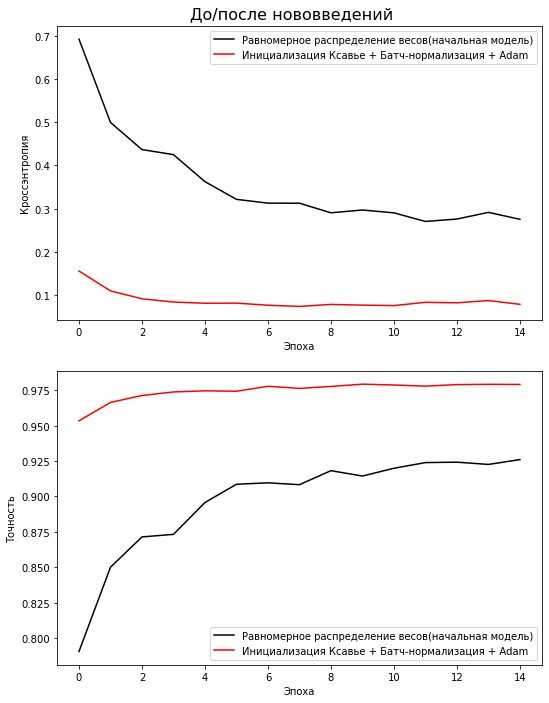

In [11]:

%matplotlib inline
fig = plt.figure(figsize=(8,10))
fig.suptitle('До/после нововведений', fontsize=16)
ax = fig.subplots(2,1)
fig.tight_layout(pad=3.0)
ax1, ax2 = ax
train_line = ax1.plot(test_loss_uniform, color = 'black')
test_line = ax1.plot(test_loss_xav, color = 'red')
ax1.set_xlabel('Эпоха')
ax1.set_ylabel('Кроссэнтропия')
ax1.legend(('Равномерное распределение весов(начальная модель)', 'Инициализация Ксавье + Батч-нормализация + Adam'))

train_line = ax2.plot(test_acc_uniform, color = 'black')
test_line = ax2.plot(test_acc_xav, color = 'red')
ax2.set_xlabel('Эпоха')
ax2.set_ylabel('Точность')
ax2.legend(('Равномерное распределение весов(начальная модель)', 'Инициализация Ксавье + Батч-нормализация + Adam'))
fig.canvas.draw()